# Cross_Sell_Prediction

In [ ]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Importing Data Set

data = pd.read_csv('/content/train_insurance.csv')
data.shape

(381109, 12)

In [ ]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
data.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,381109,NaN,NaN,NaN,190555,110017,1,95278,190555,285832,381109
Gender,381109,2,Male,206089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,381109,NaN,NaN,NaN,38.8226,15.5116,20,25,36,49,85
Driving_License,381109,NaN,NaN,NaN,0.997869,0.0461095,0,1,1,1,1
Region_Code,381109,NaN,NaN,NaN,26.3888,13.2299,0,15,28,35,52
Previously_Insured,381109,NaN,NaN,NaN,0.45821,0.498251,0,0,0,1,1
Vehicle_Age,381109,3,1-2 Year,200316,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle_Damage,381109,2,Yes,192413,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual_Premium,381109,NaN,NaN,NaN,30564.4,17213.2,2630,24405,31669,39400,540165
Policy_Sales_Channel,381109,NaN,NaN,NaN,112.034,54.204,1,29,133,152,163


In [ ]:
data.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [ ]:
# No Missing Values

data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## Visualising Data

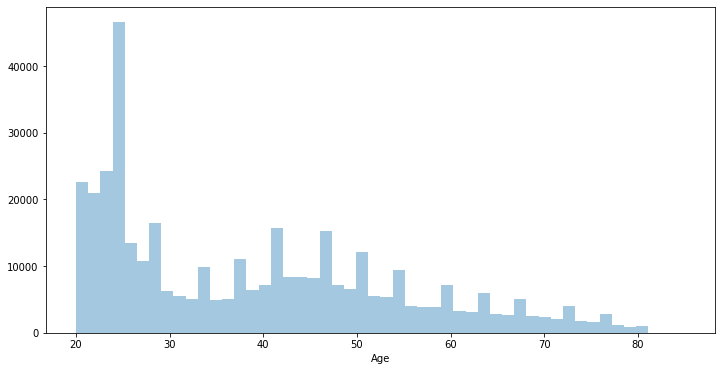

In [ ]:
plt.figure(figsize = (12, 6))
sns.distplot(data['Age'], kde = False)

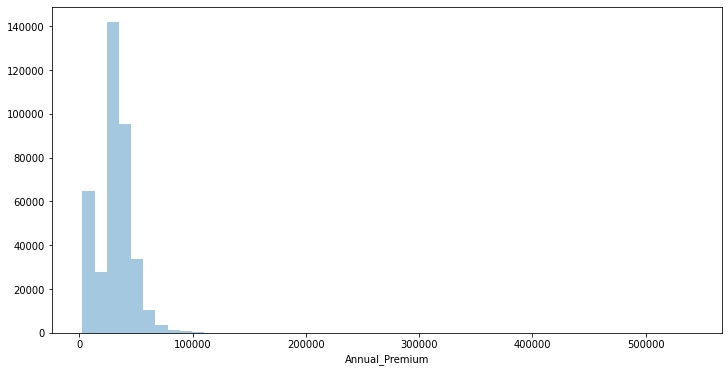

In [ ]:
plt.figure(figsize = (12, 6))
sns.distplot(data['Annual_Premium'], kde =  False)

In [ ]:
data['Age'] = np.log(data['Age'])
data['Annual_Premium'] = np.log(data['Annual_Premium'])

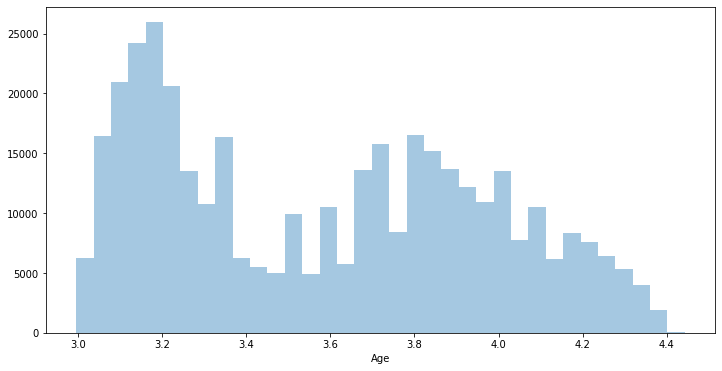

In [ ]:
plt.figure(figsize = (12, 6))
sns.distplot(data['Age'], kde = False, bins = 35)

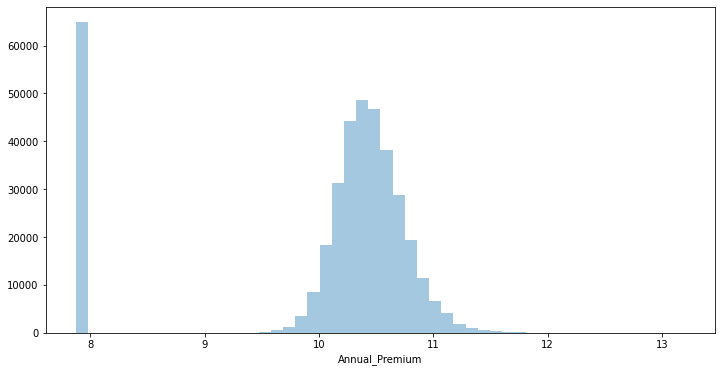

In [ ]:
plt.figure(figsize = (12, 6))
sns.distplot(data['Annual_Premium'], kde =  False)

## Data Preprocessing

In [ ]:
data['Policy_Sales_Channel'] = data['Policy_Sales_Channel'].astype('int')
data['Region_Code'] = data['Region_Code'].astype('int')

In [ ]:
cat_var = data.select_dtypes('object')

for i in cat_var:
  print("************************NEW************************")
  print(data[i].value_counts())

************************NEW************************
Male      206089
Female    175020
Name: Gender, dtype: int64
************************NEW************************
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64
************************NEW************************
Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64


In [ ]:
data['Vehicle_Age'] = data['Vehicle_Age'].map({'< 1 Year' : 0,
                                               '1-2 Year' : 1,
                                               '> 2 Years' : 2})

data['Vehicle_Damage'] = data['Vehicle_Damage'].map({'Yes' : 1,
                                                     'No' : 0})

data['Gender'] = data['Gender'].map({'Male' : 1,
                                     'Female' : 0})

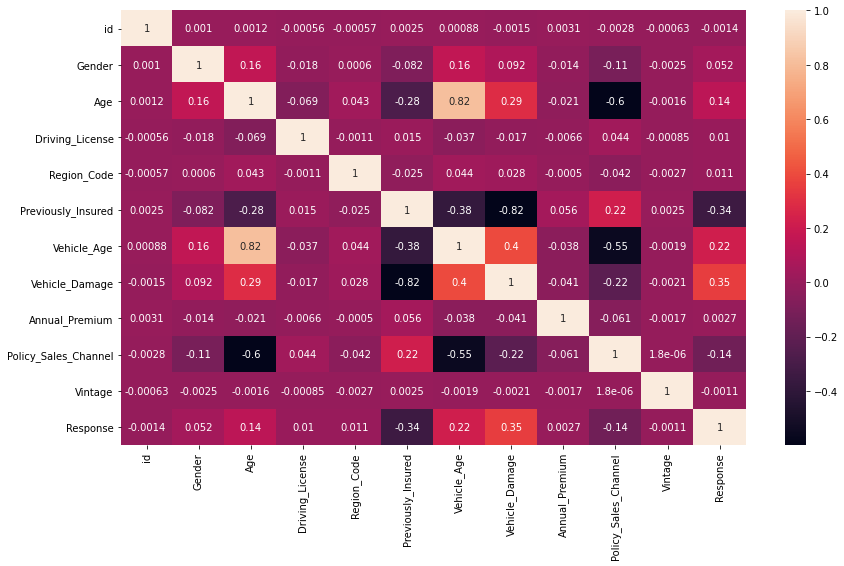

In [ ]:
plt.figure(figsize = (14, 8))
sns.heatmap(data.corr(), annot = True, robust = True)

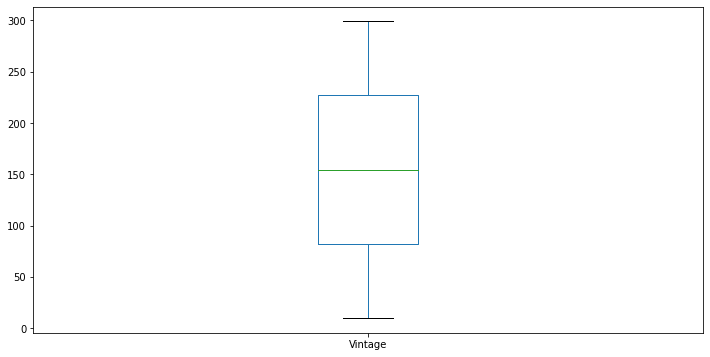

In [ ]:
plt.figure(figsize = (12, 6))
data['Vintage'].plot.box()

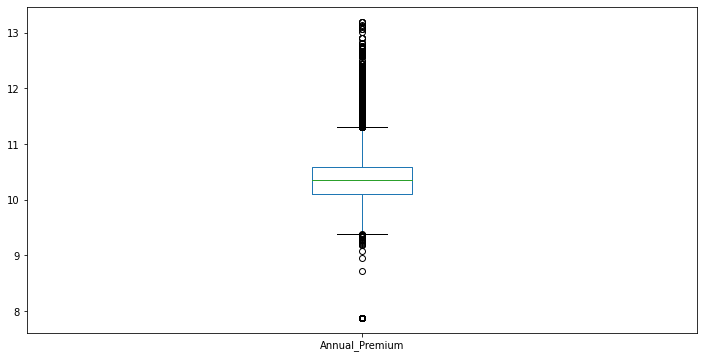

In [ ]:
plt.figure(figsize = (12, 6))
data['Annual_Premium'].plot.box()

In [ ]:
data = data[data['Annual_Premium'] < 11.25]

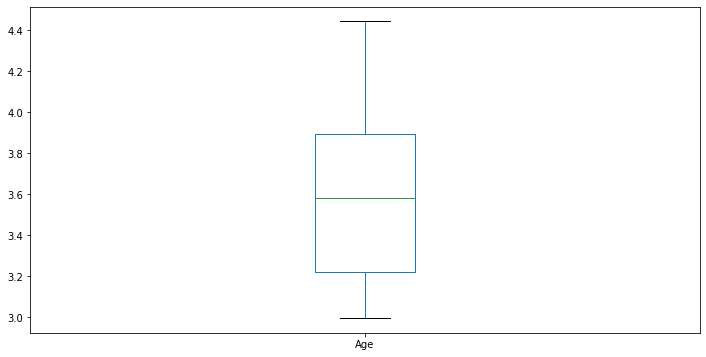

In [ ]:
plt.figure(figsize = (12, 6))
data['Age'].plot.box()

In [ ]:
x = data.drop(['id', 'Response'], axis = 1)
y = data['Response']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

## Train - Test - Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 17)

In [ ]:
scaler = StandardScaler()

scaled_x_train = scaler.fit_transform(x_train)
scaled_x_test = scaler.transform(x_test)

## Model Creation and Training

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(boosting_type = 'gbdt', n_estimators = 1000, depth = 8, learning_rate = 0.02, objective = 'binary', metric= 'auc', is_unbalance= True,
                     colsample_bytree = 0.6, reg_lambda = 4, reg_alpha = 2, random_state = 17, n_jobs = -1)

In [ ]:
lgb.fit(scaled_x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
               depth=8, importance_type='split', is_unbalance=True,
               learning_rate=0.02, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=17, reg_alpha=2, reg_lambda=4, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
print(roc_auc_score(y_test, lgb.predict_proba(scaled_x_test)[:,1]))

0.8597221966896675


## Model Performance

In [ ]:
print(classification_report(y_test, lgb.predict(scaled_x_test)))

              precision    recall  f1-score   support

           0       0.99      0.68      0.80     66387
           1       0.29      0.93      0.44      9255

    accuracy                           0.71     75642
   macro avg       0.64      0.80      0.62     75642
weighted avg       0.90      0.71      0.76     75642



In [ ]:
scaled_final_train = scaler.transform(data.drop(['id', 'Response'], axis = 1))
final_test = data['Response']

## Final Model

In [ ]:
final_lgb = LGBMClassifier(boosting_type = 'gbdt', n_estimators = 1000, depth = 9, learning_rate = 0.02, objective = 'binary', metric = 'auc',is_unbalance = True,
                           colsample_bytree = 0.6, reg_lambda = 4, reg_alpha = 2, random_state = 17, n_jobs = -1)

In [ ]:
final_lgb.fit(scaled_final_train, final_test)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
               depth=9, importance_type='split', is_unbalance=True,
               learning_rate=0.02, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=17, reg_alpha=2, reg_lambda=4, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Importing Test Data and Predicting Values of Target Variable

In [ ]:
test_data = pd.read_csv('/content/test_insurance.csv')

In [ ]:
test_data.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,127037,NaN,NaN,NaN,444628,36672.6,381110,412869,444628,476387,508146
Gender,127037,2,Male,68236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,127037,NaN,NaN,NaN,38.7659,15.4658,20,25,36,49,85
Driving_License,127037,NaN,NaN,NaN,0.998134,0.0431524,0,1,1,1,1
Region_Code,127037,NaN,NaN,NaN,26.4599,13.2099,0,15,28,35,52
Previously_Insured,127037,NaN,NaN,NaN,0.460039,0.498403,0,0,0,1,1
Vehicle_Age,127037,3,1-2 Year,66699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle_Damage,127037,2,Yes,63835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual_Premium,127037,NaN,NaN,NaN,30524.6,16945.3,2630,24325,31642,39408,472042
Policy_Sales_Channel,127037,NaN,NaN,NaN,111.8,54.3718,1,26,135,152,163


In [ ]:
test_data['Age'] = np.log(test_data['Age'])
test_data['Annual_Premium'] = np.log(test_data['Annual_Premium'])

In [ ]:
test_data['Policy_Sales_Channel'] = test_data['Policy_Sales_Channel'].astype('int')
test_data['Region_Code'] = test_data['Region_Code'].astype('int')

In [ ]:
test_data['Vehicle_Age'] = test_data['Vehicle_Age'].map({'< 1 Year' : 0,
                                                         '1-2 Year' : 1,
                                                         '> 2 Years' : 2})

test_data['Vehicle_Damage'] = test_data['Vehicle_Damage'].map({'Yes' : 1,
                                                               'No' : 0})

test_data['Gender'] = test_data['Gender'].map({'Male' : 1,
                                               'Female' : 0})

In [ ]:
test_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,1,3.218876,1,11,1,0,0,10.485312,152,53
1,381111,1,3.688879,1,28,0,1,1,10.427091,7,111
2,381112,1,3.850148,1,28,0,1,1,10.597884,124,199
3,381113,1,3.178054,1,27,1,0,1,10.528249,152,187
4,381114,1,3.295837,1,28,1,0,0,10.986935,152,297


In [ ]:
scaled_final_test = scaler.transform(test_data.drop('id', axis = 1))

In [ ]:
final_pred = final_lgb.predict(scaled_final_test)

In [ ]:
my_pred = pd.DataFrame(test_data['id'])
my_pred['Response'] = final_pred

## Saving Predictions

In [ ]:
my_pred.to_csv('AV_cross_cell_prediction.csv', index = False)